In [59]:
import pandas as pd
import numpy as np

In [7]:
df_train = pd.DataFrame(pd.read_excel('data/car_train.xlsx'))
df_test = pd.DataFrame(pd.read_excel('data/car_test.xlsx'))

df_train = df_train.drop('Unnamed: 0', axis=1)
df_test = df_test.drop('Unnamed: 0', axis=1)

In [12]:
df_test

x1   y1    x2   y2      image
0      30   52   246  147  00001.jpg
1     100   19   576  203  00002.jpg
2      51  105   968  659  00003.jpg
3      67   84   581  407  00004.jpg
4     140  151   593  339  00005.jpg
...   ...  ...   ...  ...        ...
8036   49   57  1169  669  08037.jpg
8037   23   18   640  459  08038.jpg
8038   33   27   602  252  08039.jpg
8039   33  142   521  376  08040.jpg
8040   77   73   506  380  08041.jpg

[8041 rows x 5 columns]

In [126]:
df_train

x1   y1    x2    y2  Class      image
0      39  116   569   375     14  00001.jpg
1      36  116   868   587      3  00002.jpg
2      85  109   601   381     91  00003.jpg
3     621  393  1484  1096    134  00004.jpg
4      14   36   133    99    106  00005.jpg
...   ...  ...   ...   ...    ...        ...
8139    3   44   423   336     78  08140.jpg
8140  138  150   706   523    196  08141.jpg
8141   26  246   660   449    163  08142.jpg
8142   78  526  1489   908    112  08143.jpg
8143   20  240   862   677     17  08144.jpg

[8144 rows x 6 columns]

In [34]:
CN

id                              name
0      1        AM General Hummer SUV 2000
1      2               Acura RL Sedan 2012
2      3               Acura TL Sedan 2012
3      4              Acura TL Type-S 2008
4      5              Acura TSX Sedan 2012
..   ...                               ...
191  192  Volkswagen Beetle Hatchback 2012
192  193          Volvo C30 Hatchback 2012
193  194              Volvo 240 Sedan 1993
194  195               Volvo XC90 SUV 2007
195  196     smart fortwo Convertible 2012

[196 rows x 2 columns]

In [69]:
CN

id                              name
0      1        AM General Hummer SUV 2000
1      2               Acura RL Sedan 2012
2      3               Acura TL Sedan 2012
3      4              Acura TL Type-S 2008
4      5              Acura TSX Sedan 2012
..   ...                               ...
191  192  Volkswagen Beetle Hatchback 2012
192  193          Volvo C30 Hatchback 2012
193  194              Volvo 240 Sedan 1993
194  195               Volvo XC90 SUV 2007
195  196     smart fortwo Convertible 2012

[196 rows x 2 columns]

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images/lada_dataset",
    shuffle = True,
    batch_size = BATCH_SIZE
)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xab in position 82: invalid start byte

In [10]:
class_names = dataset.class_names
len(class_names)

31

In [11]:
len(dataset)

83

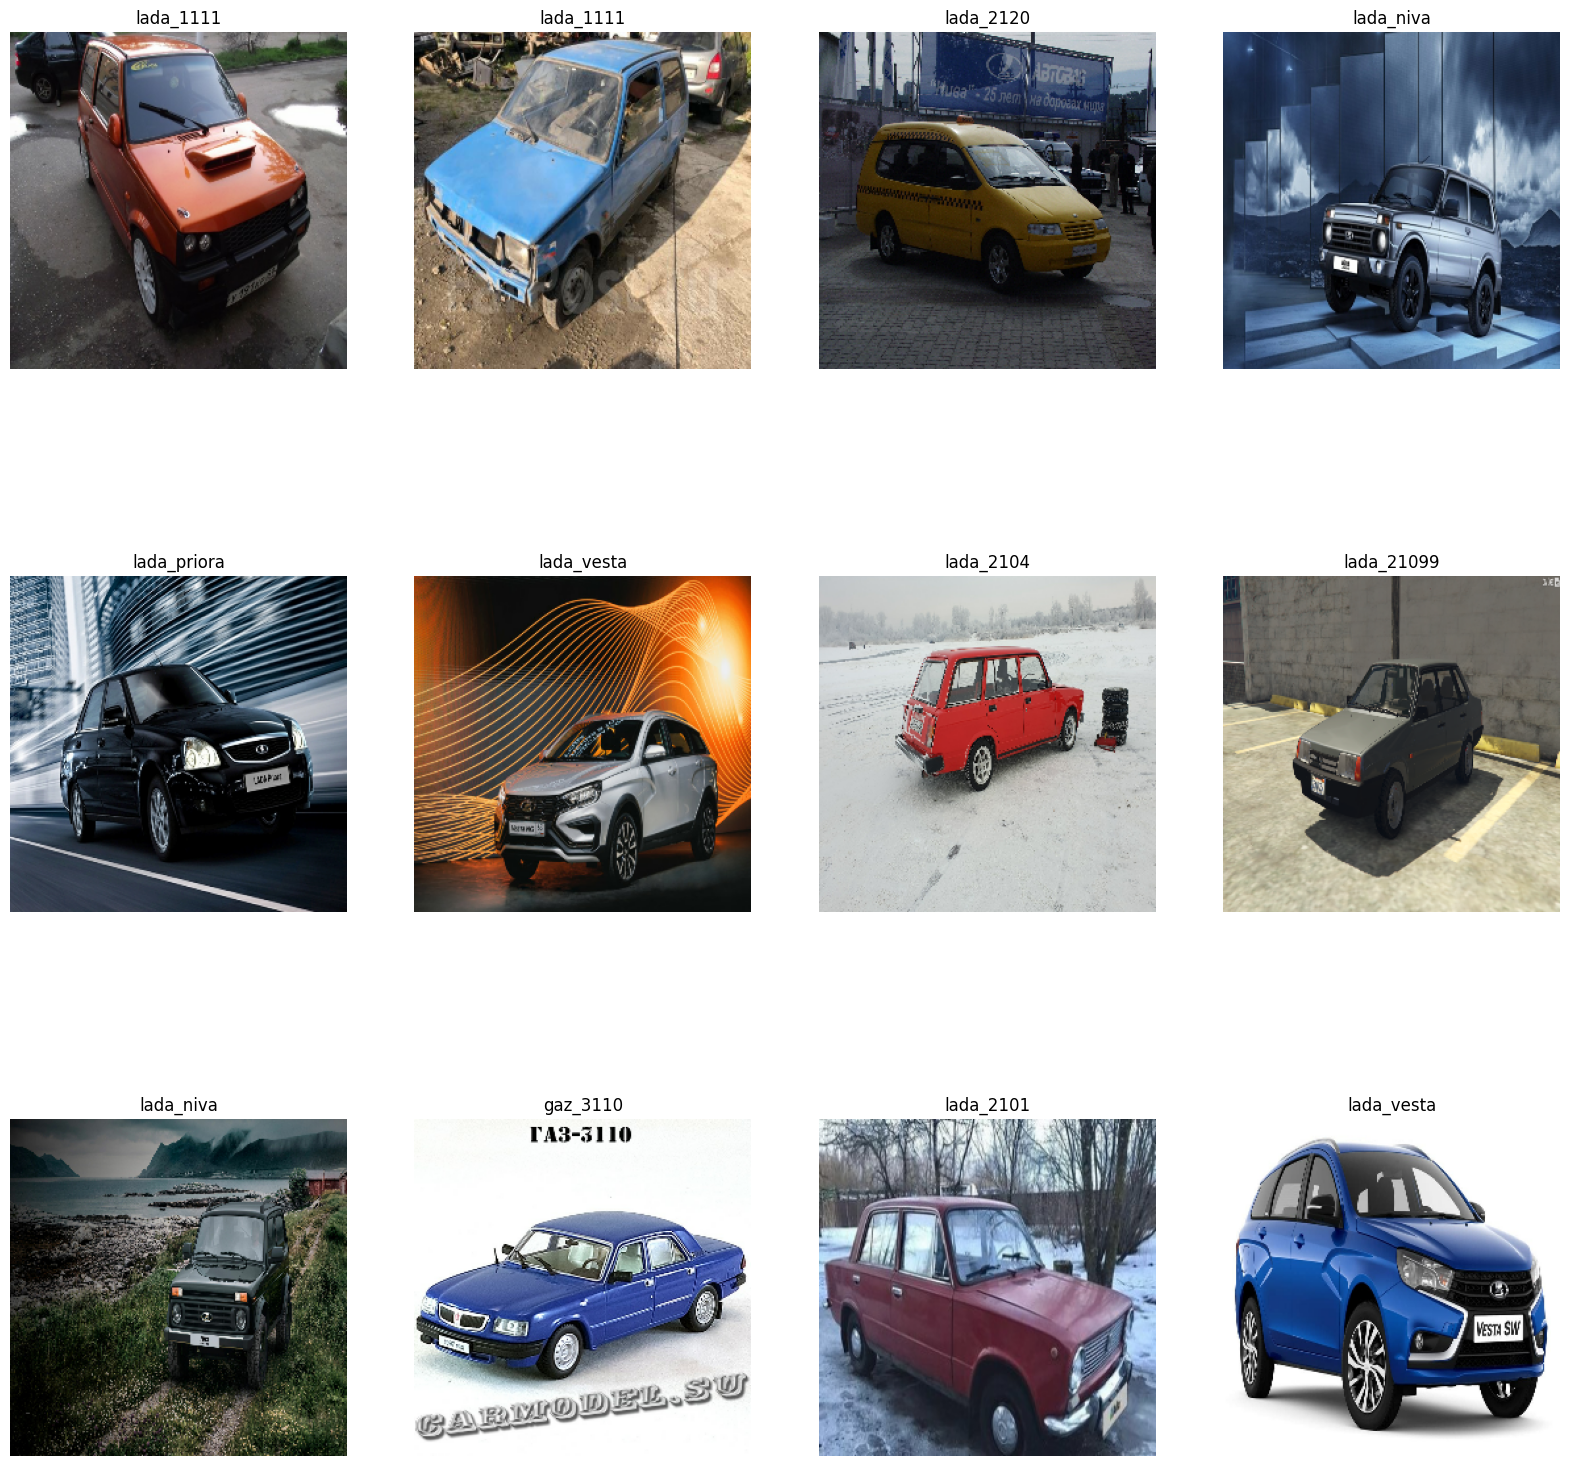

In [12]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [13]:
len(dataset)

83

In [14]:
train_size = 0.8
len(dataset)*train_size

66.4

In [15]:
train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

66

In [16]:
test_ds = dataset.skip(int(len(dataset)*train_size))
len(test_ds)

17

In [17]:
val_size = 0.1
len(dataset)*val_size

8.3

In [18]:
val_ds = test_ds.take(int(len(dataset)*val_size))
len(val_ds)

8

In [19]:
test_ds = test_ds.skip(int(len(dataset)*val_size))
len(test_ds)

9

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

66

In [23]:
len(val_ds)

8

In [24]:
len(test_ds)

9

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    # resizing & rescaling + flip & rotation
    resize_and_rescale,
#     data_augmentation,
    
    # cnn
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # dense
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
66/66 [==============================] - 110s 2s/step - loss: 3.4358 - accuracy: 0.0328 - val_loss: 3.4331 - val_accuracy: 0.0117
Epoch 2/50
66/66 [==============================] - 86s 1s/step - loss: 3.4213 - accuracy: 0.0309 - val_loss: 3.3622 - val_accuracy: 0.0430
Epoch 3/50
66/66 [==============================] - 79s 1s/step - loss: 3.3598 - accuracy: 0.0556 - val_loss: 3.2714 - val_accuracy: 0.0781
Epoch 4/50
66/66 [==============================] - 78s 1s/step - loss: 3.2836 - accuracy: 0.0675 - val_loss: 3.3441 - val_accuracy: 0.0898
Epoch 5/50
66/66 [==============================] - 78s 1s/step - loss: 3.2110 - accuracy: 0.0822 - val_loss: 3.1599 - val_accuracy: 0.0898
Epoch 6/50
66/66 [==============================] - 84s 1s/step - loss: 3.1084 - accuracy: 0.1193 - val_loss: 3.0412 - val_accuracy: 0.1172
Epoch 7/50
66/66 [==============================] - 88s 1s/step - loss: 3.0176 - accuracy: 0.1359 - val_loss: 2.9531 - val_accuracy: 0.1953
Epoch 8/50
66/66 [=

In [35]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 3s 280ms/step - loss: 3.3290 - accuracy: 0.7986


In [36]:
scores

[3.3290319442749023, 0.7986111044883728]

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 66}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history.history['accuracy']

[0.03279467672109604,
 0.030893536284565926,
 0.055608365684747696,
 0.06749049574136734,
 0.08222433179616928,
 0.11929658055305481,
 0.1359315663576126,
 0.17538022994995117,
 0.20389734208583832,
 0.25190114974975586,
 0.29515209794044495,
 0.35598859190940857,
 0.40731939673423767,
 0.48811787366867065,
 0.5423004031181335,
 0.6478136777877808,
 0.6863117814064026,
 0.73384028673172,
 0.8051331043243408,
 0.7590304017066956,
 0.8307985067367554,
 0.9054182767868042,
 0.9006654024124146,
 0.9158745408058167,
 0.9096958041191101,
 0.947718620300293,
 0.9524714946746826,
 0.9515209197998047,
 0.8479087352752686,
 0.928231954574585,
 0.9691064357757568,
 0.9610266089439392,
 0.9686312079429626,
 0.9795627593994141,
 0.9714828729629517,
 0.9762357473373413,
 0.9439163208007812,
 0.9363117814064026,
 0.983364999294281,
 0.980513334274292,
 0.9824144244194031,
 0.983364999294281,
 0.9662547707557678,
 0.9500950574874878,
 0.9534220695495605,
 0.9672053456306458,
 0.9866920113563538,
 0.99

In [42]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'training and validation accuracy')

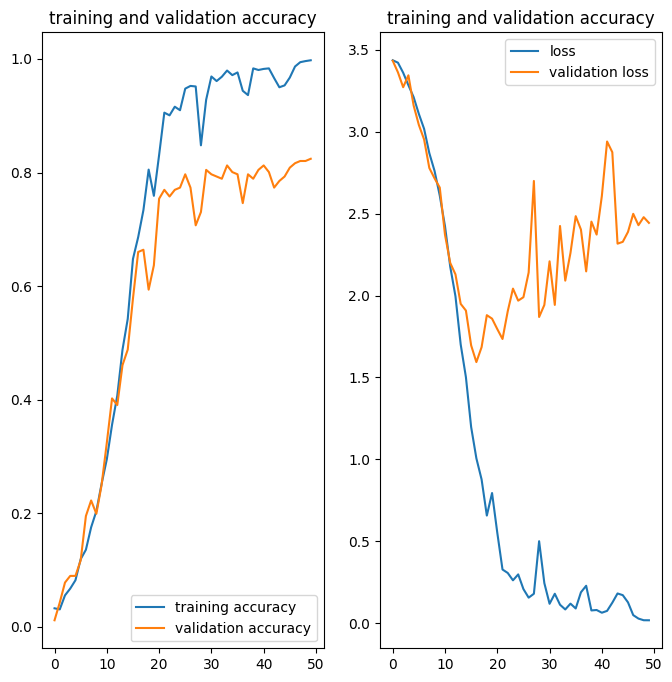

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='training accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='loss')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation accuracy')

first image_s actual label: lada_2108
predicted label: lada_2108


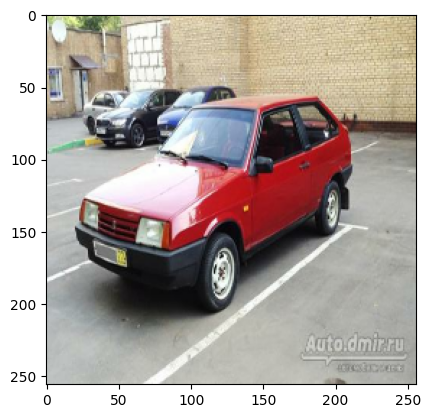

In [79]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print(f'first image_s actual label: {class_names[first_label]}')
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print(f'predicted label: {class_names[np.argmax(batch_prediction[0])]}')

In [87]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array, verbose=0)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

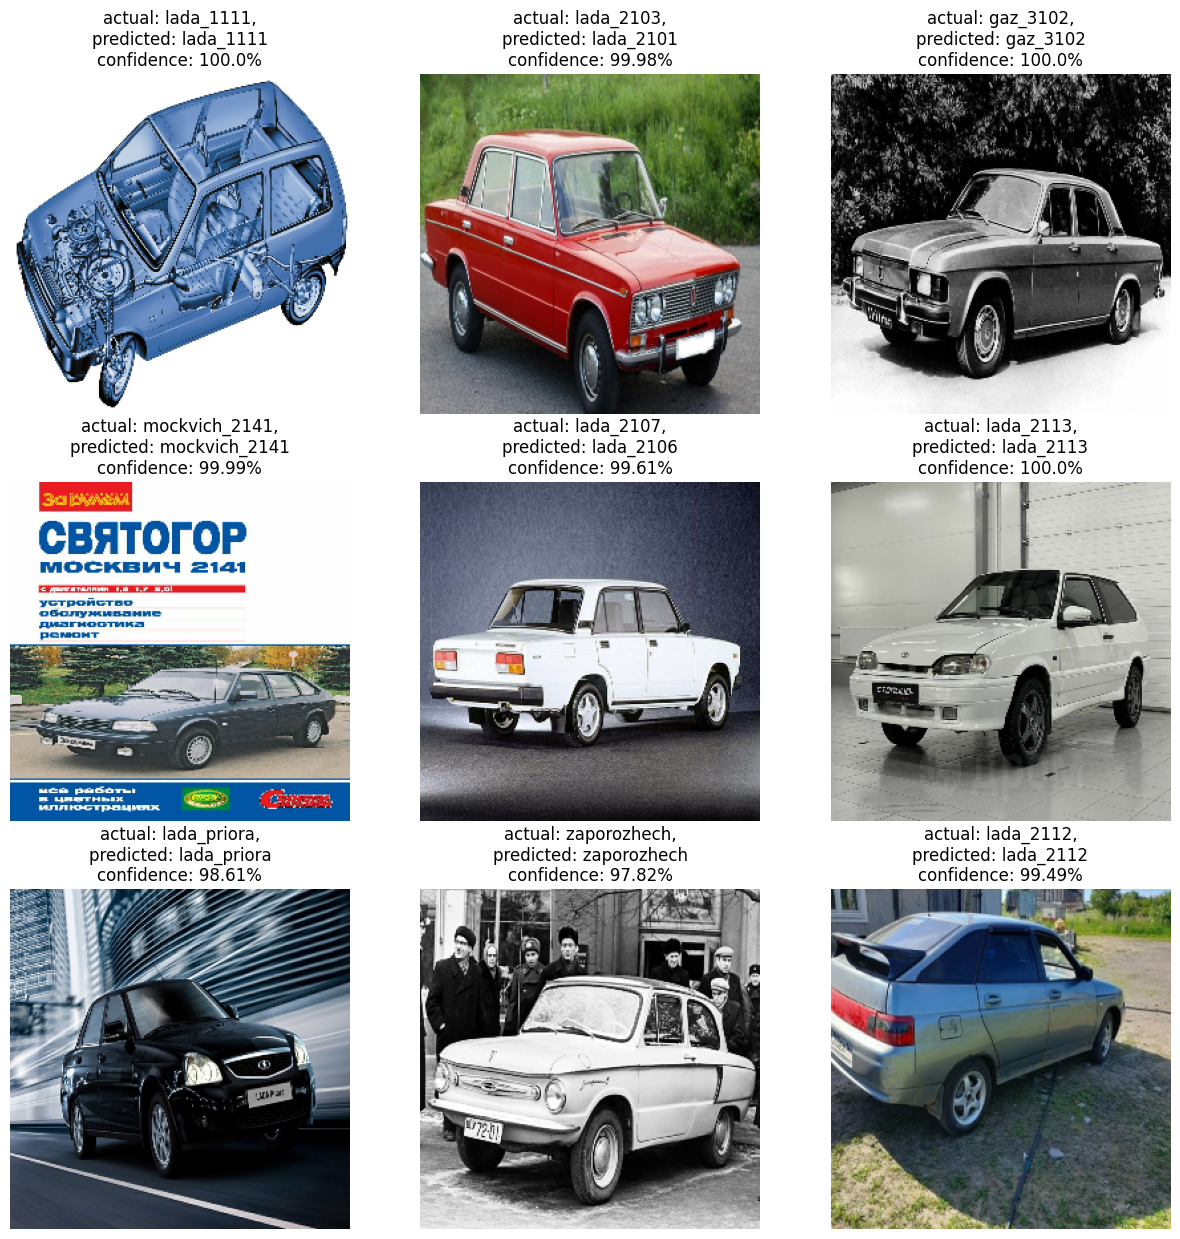

In [88]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'actual: {actual_class},\npredicted: {predicted_class}\nconfidence: {confidence}%')
        plt.axis('off')

In [ ]:
import os
model_version = max([int(i) for i in os.list])